In [5]:
import pandas as pd 

data = pd.read_csv('cupcakeslovers.csv') 
data.head()

,text,webVideoUrl,diggCount,shareCount,playCount,collectCount,commentCount,duration,musicName,musicAuthor,nickName,fans
0,𝔹𝕖𝕒𝕦𝕥𝕚𝕗𝕦𝕝 𝔹𝕝𝕦𝕖💙 What are your thoughts? 💭 #bea...,https://www.tiktok.com/@kerrysbouqcakes/video/...,173800,7256,3000000,15700,313,10,Kulture Klub (Sped up Version),Lucy Tun,Kerry's Bouqcakes,411000
1,𝕎𝕙𝕒𝕥'𝕤 𝕪𝕠𝕦𝕣 𝕗𝕒𝕧𝕠𝕦𝕣𝕚𝕥𝕖 𝕥𝕙𝕚𝕟𝕘 𝕒𝕓𝕠𝕦𝕥 ℂ𝕙𝕣𝕚𝕤𝕥𝕞𝕒𝕤? 🎄...,https://www.tiktok.com/@kerrysbouqcakes/video/...,17600,2263,486900,2296,863,49,Christmas,neozilla,Kerry's Bouqcakes,411000
2,#cupxakes #proceso #cremaverde 💚,https://www.tiktok.com/@cupcakesloversv/video/...,10,0,173,0,0,8,Run Free (Original Mix),Deep Chills,Cupcakes Lover,190
3,It's my bday... 🎉🎉🎉@CEO of Konfidinz thanks fo...,https://www.tiktok.com/@brebre0029/video/74258...,7,1,92,0,3,29,SJAYY Not Like Us FT. Kendrick Lamar,SJAYY,Bre Bre,580
4,#pastelespersonalizados #parati #cupcakeslover 💖,https://www.tiktok.com/@cupcakesloversv/video/...,257,2,2137,1,0,15,Mega Francesita (Remix),DJ Dmonio,Cupcakes Lover,190


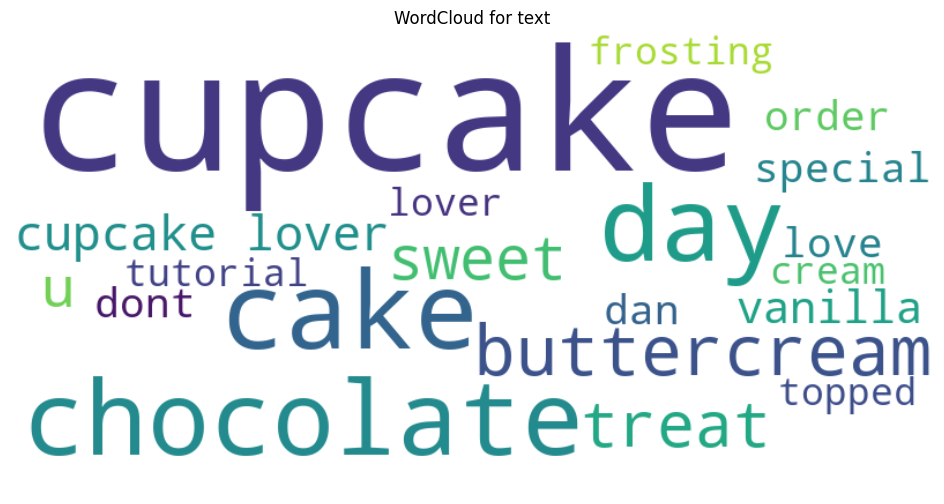

Top 10 Term Frequency:
cupcake        58
chocolate      17
cake           14
day            13
lover          13
buttercream    12
love           10
treat          10
sweet           9
apple           8
Name: count, dtype: int64


In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import unicodedata

# 1. Preparación de datos
class PrepareData(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Convertir valores de 'text' a string y manejar NaN
        X['text'] = X['text'].astype(str)

        # Normalizar texto estilizado y convertir a minúsculas
        X['text'] = X['text'].apply(self.normalize_styled_text)

        # Extraer hashtags
        X['hashtags'] = X['text'].apply(lambda x: ' '.join(re.findall(r'#\w+', x)))
        
        # Contar hashtags
        X['hashtag_count'] = X['hashtags'].apply(lambda x: len(x.split()) if x else 0)
        
        # Borrar los hashtags de la columna 'text'
        X['text'] = X['text'].str.replace(r'#\w+', '', regex=True).str.strip()

        # Eliminar caracteres no alfabéticos
        X['text'] = X['text'].str.replace(r'[^\w\s]', '', regex=True).str.strip()
        
        return X
    
    def normalize_styled_text(self, text):
        # Normaliza el texto a la forma de compresión
        normalized = unicodedata.normalize('NFKD', text)
        # Convierte a minúsculas
        return normalized.lower()

# 2. Eliminación de Stop Words
class RemoveStopwords(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Cargar stop words para inglés y español
        self.stop_words = set(stopwords.words('english')).union(set(stopwords.words('spanish')))
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['text'] = X['text'].apply(lambda text: ' '.join([word for word in text.split() if word not in self.stop_words]))
        return X

# 3. Normalización (Lemmatization)
class NormalizeTextLemmatization(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = SnowballStemmer('spanish')

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def lemmatize_text(text):
            words = text.split()
            return ' '.join([self.stemmer.stem(word) if self.detect_language(word) == 'es' else self.lemmatizer.lemmatize(word) for word in words])
        
        X['text'] = X['text'].apply(lemmatize_text)
        return X
    
    def detect_language(self, word):
        # Simple heuristic for detecting language
        if re.search(r'[ñáéíóú]', word):
            return 'es'
        else:
            return 'en'

# 4. Análisis de Ngrams
class AnalyzeNgrams(BaseEstimator, TransformerMixin):
    def __init__(self, n=2):
        self.n = n
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def get_ngrams(text, n):
            tokens = text.split()
            ngrams = zip(*[tokens[i:] for i in range(n)])
            return [' '.join(ngram) for ngram in ngrams]
        
        X[f'bigrams'] = X['text'].apply(lambda text: get_ngrams(text, 2))
        X[f'trigrams'] = X['text'].apply(lambda text: get_ngrams(text, 3))
        return X

# 5. Creación de Nubes de Palabras
def create_wordcloud(data, column):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=20).generate(' '.join(data[column]))
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for {column}")
    plt.show()

# 6. Cálculo de Frecuencia de Términos
def term_frequency(data, column):
    # Calcular la frecuencia de términos
    term_freq = pd.Series(' '.join(data[column]).split()).value_counts()
    
    # Filtrar términos que tengan más de un carácter
    term_freq = term_freq[term_freq.index.str.match(r'^\w{2,}$')]
    
    print("Top 10 Term Frequency:")
    print(term_freq.head(10))
    return term_freq

# 7. Análisis de Sentimientos
class AnalyzeSentiment(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def sentiment_category(text):
            polarity = TextBlob(text).sentiment.polarity
            if polarity > 0:
                return 'Positive'
            elif polarity < 0:
                return 'Negative'
            else:
                return 'Neutral'
        
        X[f'Sentiment_{self.column}'] = X[self.column].apply(sentiment_category)
        return X

# Pipeline principal
def main_pipeline(file_path):
    # Cargar datos desde el archivo proporcionado
    data = pd.read_csv(file_path)
    
    # Definir el pipeline
    pipeline_steps = [
        ('prepare_data', PrepareData()), 
        ('remove_stopwords', RemoveStopwords())
    ]
    
    # 2. Usamos lemmatization
    pipeline_steps.append(('normalize_text', NormalizeTextLemmatization()))
    
    # Pipeline
    pipeline = Pipeline(steps=pipeline_steps)
    
    # Aplicar el pipeline
    processed_data = pipeline.fit_transform(data)

    # 4. Análisis de Ngrams
    ngram_analyzer = AnalyzeNgrams()
    processed_data = ngram_analyzer.fit_transform(processed_data)

    # 5. Creación de Nubes de Palabras
    create_wordcloud(processed_data, 'text')
    
    # 6. Calcular la frecuencia de términos
    term_frequency(processed_data, 'text')
    
    # 7. Análisis de Sentimientos
    sentiment_pipeline = Pipeline(steps=[
        ('analyze_sentiment', AnalyzeSentiment('text'))
    ])
    processed_data = sentiment_pipeline.fit_transform(processed_data)
    return processed_data

# Llamada al pipeline
if __name__ == "__main__":
    file_path = 'cupcakeslovers.csv'
    processed_data = main_pipeline(file_path)

In [5]:
# Guardamos los datos procesados
processed_data.to_csv('processed_data.csv', index=False)

In [6]:
# Los hashtags más usados
hashtags = processed_data['hashtags'].str.split(expand=True).stack().value_counts()

In [7]:
hashtags

#cupcakes              26
#fyp                   24
#cupcake               23
#buttercream           19
#chocolate             17
                       ..
#cakeshopsanantonio     1
#bakingwithlove         1
#sugarart               1
#sanantoniosweets       1
#commentkaro            1
Name: count, Length: 840, dtype: int64

# Sentimiento analisis_extra
<!--  -->

In [8]:
import openai 
import pandas as pd
import re
from typing import Optional
from openai import OpenAI

In [9]:
def analyze_sentiment(text: Optional[str]) -> str:
    if not text:
        return "No text provided"
    
    try:
        api_key = ''

        client = OpenAI(api_key=api_key) 
        response = client.chat.completions.create(
            model="gpt-4o-mini", 
            messages=[
                {"role": "system", "content": "You are a helpful assistant that analyzes sentiment."},
                {"role": "user", "content": f"Analyze the sentiment of this text: '{text}', respond in Spanish, please"}
            ],
            max_tokens=100
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"Error: {str(e)}"
    


def analyze_sentiment_percentages(text: Optional[str]) -> str:
    if not text:
        return "No text provided"
    
    api_key = ''

    client = OpenAI(api_key=api_key)     
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a helpful assistant that analyzes sentiment."},
                {"role": "user", "content": f"Analyze the following text and provide the percentage breakdown of the main emotions (happiness, sadness, anger, fear, surprise): '{text}', would you like to give it to me in list format (ex: ['happiness':0.25, ' sadness':0.25, 'anger':0.25, 'fear':0.25, 'surprise':0.25]), just return the list to me, nothing more "}
            ],
            max_tokens=100
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"Error: {str(e)}"
    



In [10]:
processed_data['sentiment_analysis']= data['text'].apply(lambda x: analyze_sentiment(x))
processed_data['sentiment_percentages'] = data['text'].apply(lambda x: analyze_sentiment_percentages(x))

## **Pepline Final**

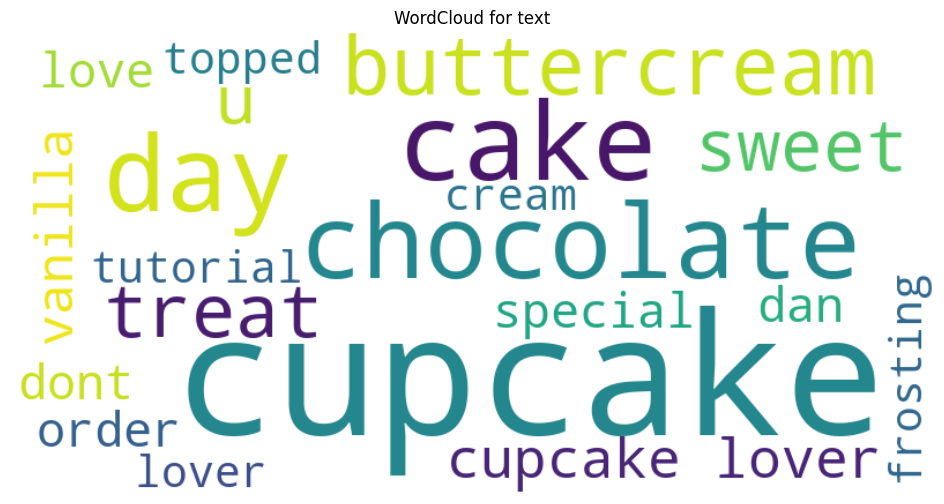

cupcake        58
chocolate      17
cake           14
day            13
lover          13
buttercream    12
love           10
treat          10
sweet           9
apple           8
Name: count, dtype: int64


In [25]:
import openai 
from openai import OpenAI
import pandas as pd
import re
import unicodedata
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from typing import Optional

# 1. Funciones de Análisis de Sentimientos
def analyze_sentiment(text: Optional[str]) -> str:
    if not text:
        return "No text provided"
    
    try:
        api_key = ''
        client = OpenAI(api_key=api_key) 
        response = client.chat.completions.create(
            model="gpt-4o-mini", 
            messages=[
                {"role": "system", "content": "You are a helpful assistant that analyzes sentiment."},
                {"role": "user", "content": f"Analyze the sentiment of this text: '{text}', respond in Spanish, please"}
            ],
            max_tokens=100
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"Error: {str(e)}"

def analyze_sentiment_percentages(text: Optional[str]) -> str:
    if not text:
        return "No text provided"
    
    api_key = ''
    client = OpenAI(api_key=api_key)     
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a helpful assistant that analyzes sentiment."},
                {"role": "user", "content": f"Analyze the following text and provide the percentage breakdown of the main emotions (happiness, sadness, anger, fear, surprise): '{text}', would you like to give it to me in list format (ex: ['happiness':0.25, ' sadness':0.25, 'anger':0.25, 'fear':0.25, 'surprise':0.25]), just return the list to me, nothing more "}
            ],
            max_tokens=100
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"Error: {str(e)}"

# 2. Cargar y preparar los datasets
def load_and_prepare_datasets():
    publicaciones_df = pd.read_csv(r'C:\Users\USER\Downloads\cupcakeslovers_publicaciones.csv')
    videos_df = pd.read_csv(r'C:\Users\USER\Downloads\cupcakeslovers_videos.csv')
    musica_df = pd.read_csv(r'C:\Users\USER\Downloads\cupcakeslovers_música.csv')
    autores_df = pd.read_csv(r'C:\Users\USER\Downloads\cupcakeslovers_autores.csv')
    
    # Seleccionar columnas necesarias
    publicaciones_df = publicaciones_df[['text', 'webVideoUrl', 'diggCount', 'shareCount', 'playCount', 'collectCount', 'commentCount']]
    videos_df = videos_df[['duration']]
    musica_df = musica_df[['musicName', 'musicAuthor']]
    autores_df = autores_df[['nickName', 'fans']]
    
    # Merge de los datasets
    df_final = pd.concat([publicaciones_df, videos_df, musica_df, autores_df], axis=1)
    return df_final

# 3. Preparación de datos
class PrepareData(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['text'] = X['text'].astype(str)
        X['text'] = X['text'].apply(self.normalize_styled_text)
        X['hashtags'] = X['text'].apply(lambda x: ' '.join(re.findall(r'#\w+', x)))
        X['hashtag_count'] = X['hashtags'].apply(lambda x: len(x.split()) if x else 0)
        X['text'] = X['text'].str.replace(r'#\w+', '', regex=True).str.strip()
        X['text'] = X['text'].str.replace(r'[^\w\s]', '', regex=True).str.strip()
        return X
    
    def normalize_styled_text(self, text):
        normalized = unicodedata.normalize('NFKD', text)
        return normalized.lower()

# 4. Eliminación de Stop Words
class RemoveStopwords(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english')).union(set(stopwords.words('spanish')))
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['text'] = X['text'].apply(lambda text: ' '.join([word for word in text.split() if word not in self.stop_words]))
        return X

# 5. Normalización (Lemmatization)
class NormalizeTextLemmatization(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = SnowballStemmer('spanish')

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def lemmatize_text(text):
            words = text.split()
            return ' '.join([self.stemmer.stem(word) if self.detect_language(word) == 'es' else self.lemmatizer.lemmatize(word) for word in words])
        
        X['text'] = X['text'].apply(lemmatize_text)
        return X
    
    def detect_language(self, word):
        if re.search(r'[ñáéíóú]', word):
            return 'es'
        else:
            return 'en'

# 6. Análisis de Ngrams
class AnalyzeNgrams(BaseEstimator, TransformerMixin):
    def __init__(self, n=2):
        self.n = n
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def get_ngrams(text, n):
            tokens = text.split()
            ngrams = zip(*[tokens[i:] for i in range(n)])
            return [' '.join(ngram) for ngram in ngrams]
        
        X[f'bigrams'] = X['text'].apply(lambda text: get_ngrams(text, 2))
        X[f'trigrams'] = X['text'].apply(lambda text: get_ngrams(text, 3))
        return X

# 7. Creación de Nubes de Palabras
def create_wordcloud(data, column):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=20).generate(' '.join(data[column]))
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for {column}")
    plt.show()

# 8. Cálculo de Frecuencia de Términos
def term_frequency(data, column):
    term_freq = pd.Series(' '.join(data[column]).split()).value_counts()
    term_freq = term_freq[term_freq.index.str.match(r'^\w{2,}$')]
    return term_freq.head(10)

# 9. Análisis de Sentimientos
class AnalyzeSentiment(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Análisis de sentimiento en texto principal
        X['sentiment_analysis'] = X['text'].apply(lambda x: analyze_sentiment(x))
        X['sentiment_percentages'] = X['text'].apply(lambda x: analyze_sentiment_percentages(x))
        
        # Análisis de sentimiento en hashtags
        X['hashtags_sentiment'] = X['hashtags'].apply(lambda x: analyze_sentiment(x) if x else "No hashtags")
        X['hashtags_percentages'] = X['hashtags'].apply(lambda x: analyze_sentiment_percentages(x) if x else "No hashtags")
        
        return X

# Pipeline principal
def main_pipeline():
    # Cargar y preparar datos
    data = load_and_prepare_datasets()
    
    # Definir el pipeline
    pipeline_steps = [
        ('prepare_data', PrepareData()), 
        ('remove_stopwords', RemoveStopwords()),
        ('normalize_text', NormalizeTextLemmatization()),
        ('analyze_ngrams', AnalyzeNgrams()),
        ('analyze_sentiment', AnalyzeSentiment())
    ]
    
    pipeline = Pipeline(pipeline_steps)
    processed_data = pipeline.fit_transform(data)
    
    # Crear WordClouds
    create_wordcloud(processed_data, 'text')
    
    # Calcular y mostrar frecuencia de términos
    term_freq = term_frequency(processed_data, 'text')
    print(term_freq)
    
    return processed_data

# Ejecución del pipeline
if __name__ == '__main__':
    processed_data = main_pipeline()

In [26]:
processed_data.head()

,text,webVideoUrl,diggCount,shareCount,playCount,collectCount,commentCount,duration,musicName,musicAuthor,nickName,fans,hashtags,hashtag_count,bigrams,trigrams,sentiment_analysis,sentiment_percentages,hashtags_sentiment,hashtags_percentages
0,beautiful blue thought,https://www.tiktok.com/@kerrysbouqcakes/video/...,173800,7256,3000000,15700,313,10,Kulture Klub (Sped up Version),Lucy Tun,Kerry's Bouqcakes,411000,#beautifulblue #blue #buttercream #buttercream...,17,"[beautiful blue, blue thought]",[beautiful blue thought],"La frase ""beautiful blue thought"" evoca un sen...","['happiness':0.6, 'sadness':0.0, 'anger':0.0, ...",El sentimiento del texto es muy positivo. Las ...,"['happiness': 0.80, 'sadness': 0.05, 'anger': ..."
1,whats favourite thing christmas long go certai...,https://www.tiktok.com/@kerrysbouqcakes/video/...,17600,2263,486900,2296,863,49,Christmas,neozilla,Kerry's Bouqcakes,411000,#buttercream #floralcupcakes #floralpiping #cu...,15,"[whats favourite, favourite thing, thing chris...","[whats favourite thing, favourite thing christ...",La sentencia tiene un sentimiento positivo. Ex...,"['happiness':0.6, 'sadness':0.1, 'anger':0.0, ...",El sentimiento del texto es muy positivo y fes...,"['happiness': 0.8, 'sadness': 0.0, 'anger': 0...."
2,,https://www.tiktok.com/@cupcakesloversv/video/...,10,0,173,0,0,8,Run Free (Original Mix),Deep Chills,Cupcakes Lover,190,#cupxakes #proceso #cremaverde,3,[],[],No text provided,No text provided,"El texto presenta un tono neutro, ya que se co...","['happiness':0.70, 'sadness':0.05, 'anger':0.0..."
3,bday ceo konfidinz thanks cupcakesthey taste good,https://www.tiktok.com/@brebre0029/video/74258...,7,1,92,0,3,29,SJAYY Not Like Us FT. Kendrick Lamar,SJAYY,Bre Bre,580,#cupcakelovers #sweets #bdaygirl #bdayqueen #v...,5,"[bday ceo, ceo konfidinz, konfidinz thanks, th...","[bday ceo konfidinz, ceo konfidinz thanks, kon...",El sentimiento del texto es mayormente positiv...,"['happiness':0.6, 'sadness':0.0, 'anger':0.0, ...",La sentiment del texto es positivo y alegre. L...,"['happiness':0.75, 'sadness':0.0, 'anger':0.0,..."
4,,https://www.tiktok.com/@cupcakesloversv/video/...,257,2,2137,1,0,15,Mega Francesita (Remix),DJ Dmonio,Cupcakes Lover,190,#pastelespersonalizados #parati #cupcakeslover,3,[],[],No text provided,No text provided,El texto muestra un sentimiento positivo. Las ...,"['happiness': 0.80, 'sadness': 0.00, 'anger': ..."


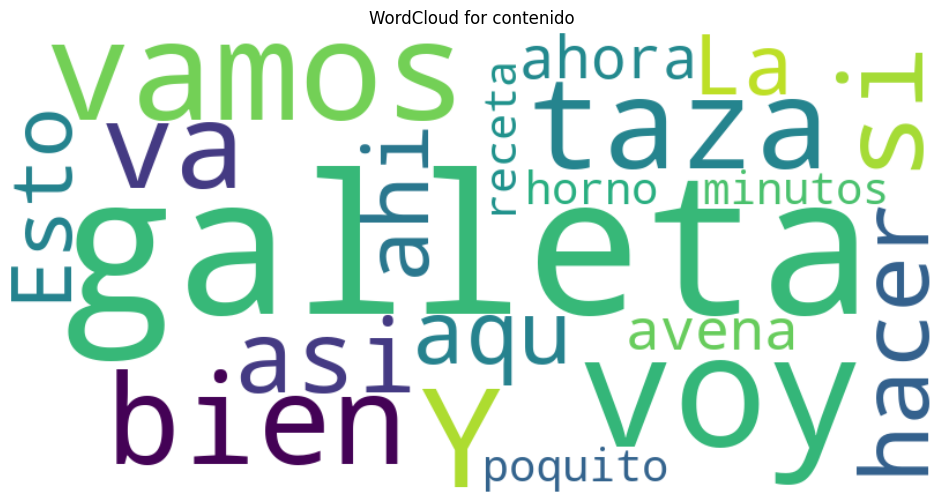

voy         49
galletas    47
va          33
vamos       31
aqu         25
bien        23
asi         23
hacer       23
azuc        21
galleta     21
Name: count, dtype: int64


In [24]:
import os
import pandas as pd
import re
import unicodedata
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# 1. Cargar y preparar los archivos de texto
directorio = r'C:\Users\USER\Downloads\Transcripción'

contenidos = []

for archivo_nombre in os.listdir(directorio):
    if archivo_nombre.endswith('.txt'): 
        ruta_archivo = os.path.join(directorio, archivo_nombre)
        with open(ruta_archivo, 'r', encoding='utf-8') as archivo:
            contenido = archivo.read()
            contenidos.append(contenido)

df = pd.DataFrame({'contenido': contenidos})

# 2. Eliminación de Stop Words
class RemoveStopwords(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english')).union(set(stopwords.words('spanish')))
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['contenido'] = X['contenido'].apply(lambda text: ' '.join([word for word in text.split() if word not in self.stop_words]))
        return X

# 3. Normalización (Lemmatization)
class NormalizeTextLemmatization(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = SnowballStemmer('spanish')

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def lemmatize_text(text):
            words = text.split()
            # Aplicamos stemming si es en español, o lematización si es en inglés
            return ' '.join([self.stemmer.stem(word) if self.detect_language(word) == 'es' else self.lemmatizer.lemmatize(word) for word in words])
        
        X['contenido'] = X['contenido'].apply(lemmatize_text)
        return X
    
    def detect_language(self, word):
        # Detecta si es español o inglés, basado en la presencia de caracteres especiales
        if re.search(r'[ñáéíóú]', word):
            return 'es'
        else:
            return 'en'

# 4. Análisis de Ngrams
class AnalyzeNgrams(BaseEstimator, TransformerMixin):
    def __init__(self, n=2):
        self.n = n
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def get_ngrams(text, n):
            tokens = text.split()
            ngrams = zip(*[tokens[i:] for i in range(n)])
            return [' '.join(ngram) for ngram in ngrams]
        
        X[f'bigrams'] = X['contenido'].apply(lambda text: get_ngrams(text, 2))
        X[f'trigrams'] = X['contenido'].apply(lambda text: get_ngrams(text, 3))
        return X

# 5. Creación de Nubes de Palabras
def create_wordcloud(data, column):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=20).generate(' '.join(data[column]))
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for {column}")
    plt.show()

# 6. Cálculo de Frecuencia de Términos
def term_frequency(data, column):
    term_freq = pd.Series(' '.join(data[column]).split()).value_counts()
    term_freq = term_freq[term_freq.index.str.match(r'^\w{2,}$')]
    return term_freq.head(10)

# Pipeline principal
def main_pipeline():
    # Definir el pipeline
    pipeline_steps = [
        ('remove_stopwords', RemoveStopwords()),
        ('normalize_text', NormalizeTextLemmatization()),
        ('analyze_ngrams', AnalyzeNgrams())
    ]
    
    pipeline = Pipeline(pipeline_steps)
    processed_data = pipeline.fit_transform(df)
    
    # Crear WordClouds
    create_wordcloud(processed_data, 'contenido')
    
    # Calcular y mostrar frecuencia de términos
    term_freq = term_frequency(processed_data, 'contenido')
    print(term_freq)
    
    return processed_data

# Ejecución del pipeline
if __name__ == '__main__':
    processed_data = main_pipeline()

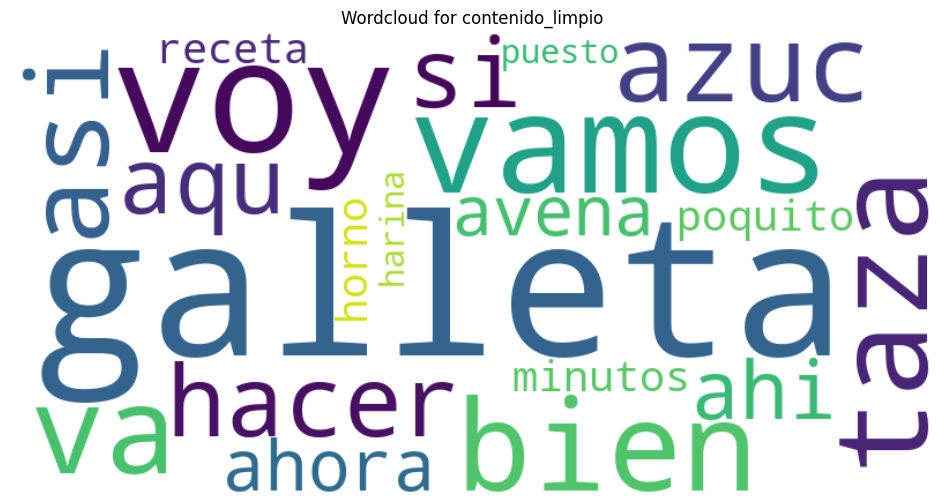

galletas    64
voy         56
vamos       44
bien        35
va          33
asi         28
aqu         26
galleta     26
taza        25
azuc        25
Name: count, dtype: int64


In [30]:
import os
import pandas as pd
import re
import unicodedata
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# 1. Cargar y preparar los archivos de texto
directorio = r'c:\users\user\downloads\transcripción'

contenidos = []

for archivo_nombre in os.listdir(directorio):
    if archivo_nombre.endswith('.txt'):
        ruta_archivo = os.path.join(directorio, archivo_nombre)
        with open(ruta_archivo, 'r', encoding='utf-8') as archivo:
            contenido = archivo.read()
            contenidos.append(contenido)

df = pd.DataFrame({'contenido': contenidos})

# 2. Limpieza de contenido (minusculizar y eliminar puntuación)
def limpiar_contenido(texto):
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar signos de puntuación
    texto = re.sub(r'[^\w\s]', '', texto)
    return texto

# Aplicar la limpieza al DataFrame y crear la nueva columna
df['contenido_limpio'] = df['contenido'].apply(limpiar_contenido)

# 3. Eliminación de stop words
class RemoveStopWords(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english')).union(set(stopwords.words('spanish')))
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['contenido_limpio'] = X['contenido_limpio'].apply(lambda text: ' '.join([word for word in text.split() if word not in self.stop_words]))
        return X

# 4. Normalización (lemmatización y stemming)
class NormalizeTextLemmatization(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = SnowballStemmer('spanish')

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def lemmatize_text(text):
            words = text.split()
            # Aplicar stemming si es español, o lematización si es en inglés
            return ' '.join([self.stemmer.stem(word) if self.detect_language(word) == 'es' else self.lemmatizer.lemmatize(word) for word in words])
        
        X['contenido_limpio'] = X['contenido_limpio'].apply(lemmatize_text)
        return X
    
    def detect_language(self, word):
        # Detecta si es español o inglés, basado en la presencia de caracteres especiales
        if re.search(r'[ñáéíóú]', word):
            return 'es'
        else:
            return 'en'

# 5. Análisis de ngrams
class AnalyzeNGrams(BaseEstimator, TransformerMixin):
    def __init__(self, n=2):
        self.n = n
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def get_ngrams(text, n):
            tokens = text.split()
            ngrams = zip(*[tokens[i:] for i in range(n)])
            return [' '.join(ngram) for ngram in ngrams]
        
        X[f'bigrams'] = X['contenido_limpio'].apply(lambda text: get_ngrams(text, 2))
        return X

# 6. Creación de nubes de palabras
def create_wordcloud(data, column):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=20).generate(' '.join(data[column]))
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Wordcloud for {column}")
    plt.show()

# 7. Cálculo de frecuencia de términos
def term_frequency(data, column):
    term_freq = pd.Series(' '.join(data[column]).split()).value_counts()
    term_freq = term_freq[term_freq.index.str.match(r'^\w{2,}$')]
    return term_freq.head(10)

# 8. Pipeline principal
def main_pipeline():
    # Definir el pipeline
    pipeline_steps = [
        ('remove_stopwords', RemoveStopWords()),
        ('normalize_text', NormalizeTextLemmatization()),
        ('analyze_ngrams', AnalyzeNGrams())
    ]
    
    pipeline = Pipeline(steps=pipeline_steps)
    processed_data = pipeline.fit_transform(df)
    
    # Crear wordcloud
    create_wordcloud(processed_data, 'contenido_limpio')
    
    # Calcular y mostrar frecuencia de términos
    term_freq = term_frequency(processed_data, 'contenido_limpio')
    print(term_freq)
    
    return processed_data

# Ejecución del pipeline
if __name__ == '__main__':
    processed_data = main_pipeline()

In [31]:
processed_data

,contenido,contenido_limpio,bigrams
0,Ya vamos a hacer rating de las galletas que ve...,vamos hacer rating galletas venden peru aburri...,"[vamos hacer, hacer rating, rating galletas, g..."
1,"Hola chicas, buenas noches. Y de veras que son...",hola chicas buenas noches veras noches 12 noch...,"[hola chicas, chicas buenas, buenas noches, no..."
2,calificando las galletas de Joy Bakery con mi ...,calificando galletas joy bakery mejor amiga ca...,"[calificando galletas, galletas joy, joy baker..."
3,"Buenas, cómo andan? Vamos a hacer unas cracke...",buenas com andan vamos hacer unas cracker crac...,"[buenas com, com andan, andan vamos, vamos hac..."
4,Hoy les enseño a hacer las mejores chocolate c...,hoy enseñ hacer mejores chocolate chip cooky s...,"[hoy enseñ, enseñ hacer, hacer mejores, mejore..."
5,"Panenas de marisa, versión Marycooking con sol...",panenas marisa version marycooking solo 7 ingr...,"[panenas marisa, marisa version, version maryc..."
6,crujientes de avena con sólo 7 ingredientes si...,crujientes avena sol 7 ingredientes azuc añad ...,"[crujientes avena, avena sol, sol 7, 7 ingredi..."
7,y aquí les va la receta de galletas de avena d...,aqu va receta galletas avena mam asi manos obr...,"[aqu va, va receta, receta galletas, galletas ..."
8,"Pues bien, hoy les voy a compartir la receta d...",pues bien hoy voy compartir receta ricas galle...,"[pues bien, bien hoy, hoy voy, voy compartir, ..."
9,Las galletas con proteínas más baratas del me...,galletas protein baratas mercado peruanas dia ...,"[galletas protein, protein baratas, baratas me..."


In [32]:
# Guardamos los datos procesados
processed_data.to_csv('processed_data2.csv', index=False)